In [2]:
#!/usr/bin/env python
#DBR last updated 07/2019
#this code performs cross-validation on predictions of variables frmo clinical outcomes
#needs the df which is imported and can be remade using sa_global

%matplotlib inline  

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st 
import sklearn.linear_model as slm 
import resource; resource.setrlimit(resource.RLIMIT_NOFILE, (1000,-1)) #allow many plots


In [3]:
sa_df=pd.read_csv('data/sa_df.csv').iloc[:, 1:] #print the csv for later analysis

sa_df.head()

,log10phi,f_r,log10x_50,A0,PE,fpvls_avg,fpvls_std,IC50s_avg,IC50s_std,dose
0,-0.519067,0.030984,1.586755,1.0,0.988636,6.096654,0.000000,1.69897,0.0,10.0
1,-0.089049,0.076860,1.287647,1.0,0.965909,4.627920,0.965111,1.69897,0.0,10.0
2,-0.559480,0.109877,1.184044,0.0,0.920455,5.224234,1.411772,1.69897,0.0,10.0
3,-0.433630,0.050762,1.608808,2.0,0.965909,4.212950,1.128564,1.69897,0.0,10.0
4,-0.182637,0.005829,1.162385,0.0,0.988636,5.727723,0.000000,1.69897,0.0,10.0


In [4]:
#labels etc for plotting

trialcolz=['teal','tan']
D=[10,30]

short_outz_labels=['PE','mean VL1','std dev VL1','mean IC50','std dev IC50']
long_outz_labels=['prevention efficacy (%)',
                  'mean VL1 log10(copies/mL)',
                  'std dev VL1 log10(copies/mL)',
                  'mean IC50 log10($\mu$g/mL)',
                  'std dev IC50 log10($\mu$g/mL)']

short_varz_labels=[r'$\log_{10}\phi$',r'$f$',r'$\log_{10}x_{50}$',r'$A_0$']
long_varz_labels=[r'potency reduction factor, $\log_{10}\phi$',
                  r'resistant fraction, $f$',
                  r'maximum IC50 $\log_{10}x_{50}$',
                  r'initial number infected cells $A_0$']

#standardize limits/ticks
ytickz=[[0,0.25,0.5,0.75,1],
       [0,1,2,3,4,5,6,7],
       [1,2,3],
       [-1,0,1,2],
       [0,1,2]]

xtickz=[[0,1,2,3],
       [0,0.2,0.4,0.6,0.8,1],
       [2,3,4],
       [0,5,10,15,20]]


sa_v = ['log10phi','f_r','log10x_50','A0']
sa_o = ['PE','fpvls_avg','fpvls_std','IC50s_avg','IC50s_std']


/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide


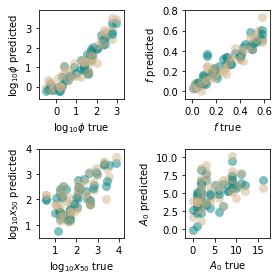

In [57]:
#check on the accuracy of the regression (predictability?)

cross_vals=5
tot_err_l=[]
rel_err_l=[]

plt.figure(figsize=(4,4))
for nv in range(cross_vals):

    num_train=50
    num_test=10

    nts=int(len(sa_df)/2)
    x=np.arange(nts)
    np.random.shuffle(x)
    xs=list(x) #make a shuffled list of indicies

    tot_errz=np.zeros([len(D),len(short_varz_labels),num_test])
    rel_errz=np.zeros([len(D),len(short_varz_labels),num_test])
    
    for iid in range(len(D)):
        tdf=sa_df[sa_df['dose']==D[iid]]

        g_out=np.array(tdf.iloc[:,4:-1]).T #just the output variables
        g_out[np.isnan(g_out)]=0 #not too many of these, hopefully doesn't mess it up too much

        varz=np.array(tdf.iloc[:,:5]).T #just the sa variables

        #loop over each sensitivity analysis variable, and see if (or how well) we can infer it
        for v in range(len(short_varz_labels)):    

            reg = slm.LinearRegression() #define a regression object #reg.set_params(normalize=True)
            reg.fit(g_out.T[xs[:num_train]],varz[v,xs[:num_train]]) #fit on rtaining set

            plt.subplot(221+v)
            true=varz[v,xs[num_train:num_test+num_train]]
            test=reg.predict(g_out.T[xs[num_train:num_test+num_train]])

            plt.scatter(true,test,lw=0,color=trialcolz[iid],s=80,alpha=0.5)

            #calculate error
            tot_errz[iid,v,:]=true-test

            if v==0 or v==2:
                rel_errz[iid,v,:]=np.abs(10**true-10**test)/10**true*100
            if v==1 or v==3:
                rel_errz[iid,v,:]=np.abs(true-test)/true*100

            tot_err_l.append(tot_errz)
            rel_err_l.append(rel_errz)
            
            plt.ylabel(short_varz_labels[v]+' predicted')
            plt.xlabel(short_varz_labels[v]+' true')

            #plt.xlim([np.min(xtickz[v]),np.max(xtickz[v])])
            #plt.ylim([np.min(xtickz[v]),np.max(xtickz[v])])

            #plt.yticks(xtickz[v]);
            #plt.xticks(xtickz[v])
            
            plt.locator_params(nbins=6)

plt.tight_layout()
plt.savefig('figures/gsense_pred1.pdf',dpi=600)
    

/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


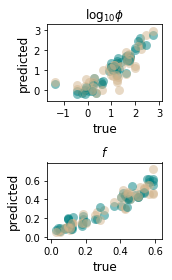

In [75]:
#check on the accuracy of the regression (predictability?)
#uses cross validation
#just the top 2

cross_vals=5
tot_err_l=[]
rel_err_l=[]

plt.figure(figsize=(2.5,4))
for nv in range(cross_vals):

    num_train=50
    num_test=10

    nts=int(len(sa_df)/2)
    x=np.arange(nts)
    np.random.shuffle(x)
    xs=list(x) #make a shuffled list of indicies

    tot_errz=np.zeros([len(D),len(short_varz_labels),num_test])
    rel_errz=np.zeros([len(D),len(short_varz_labels),num_test])
    
    for iid in range(len(D)):
        tdf=sa_df[sa_df['dose']==D[iid]]

        g_out=np.array(tdf.iloc[:,4:-1]).T #just the output variables
        g_out[np.isnan(g_out)]=0 #not too many of these, hopefully doesn't mess it up too much

        varz=np.array(tdf.iloc[:,:5]).T #just the sa variables

        #loop over each sensitivity analysis variable, and see if (or how well) we can infer it
        for v in range(2):    

            reg = slm.LinearRegression() #define a regression object #reg.set_params(normalize=True)
            reg.fit(g_out.T[xs[:num_train]],varz[v,xs[:num_train]]) #fit on rtaining set

            plt.subplot(211+v)
            true=varz[v,xs[num_train:num_test+num_train]]
            test=reg.predict(g_out.T[xs[num_train:num_test+num_train]])

            plt.scatter(true,test,lw=0,color=trialcolz[iid],s=80,alpha=0.5)

            #calculate error
            tot_errz[iid,v,:]=true-test

            if v==0 or v==2:
                rel_errz[iid,v,:]=np.abs(10**true-10**test)/10**true*100
            if v==1 or v==3:
                rel_errz[iid,v,:]=np.abs(true-test)/true*100

            tot_err_l.append(tot_errz)
            rel_err_l.append(rel_errz)
            
            plt.ylabel('predicted',fontsize=12)
            plt.xlabel('true',fontsize=12)
            plt.title(short_varz_labels[v])            
            plt.locator_params(nbins=6)

plt.tight_layout()
plt.savefig('figures/gsense_pred12.pdf',dpi=600)
    

/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


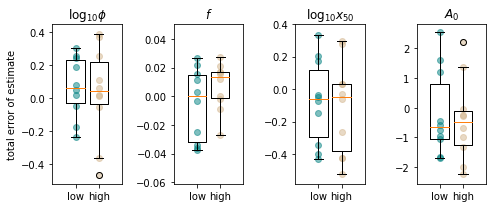

In [58]:
#plot total errors
plt.figure(figsize=(7,3))
for iid in range(len(D)):
    for v in range(len(short_varz_labels)):    
        plt.subplot(141+v)
        plt.scatter(np.ones(num_test)+iid/2,np.mean(tot_err_l,0)[iid,v,:],color=trialcolz[iid],alpha=0.5)
        plt.boxplot(np.mean(tot_err_l,0)[iid,v,:],positions=[1+iid/2],widths=0.4)    

        plt.title(short_varz_labels[v])
        if v==0:
            plt.ylabel('total error of estimate')
        plt.xticks([])
        
        plt.xlim([0.5,2])
        #plt.ylim([-5,200])
        plt.xticks([1,1.5],['low','high'])

plt.tight_layout()
plt.savefig('figures/gsense_pred2.pdf')


/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


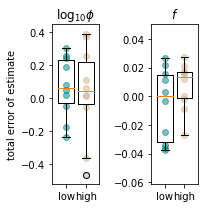

In [67]:
#plot total errors -- just the first 2
plt.figure(figsize=(3,3))
for iid in range(len(D)):
    for v in range(2):    
        plt.subplot(121+v)
        plt.scatter(np.ones(num_test)+iid/2,np.mean(tot_err_l,0)[iid,v,:],color=trialcolz[iid],alpha=0.5)
        plt.boxplot(np.mean(tot_err_l,0)[iid,v,:],positions=[1+iid/2],widths=0.4)    

        plt.title(short_varz_labels[v])
        if v==0:
            plt.ylabel('total error of estimate')
        plt.xticks([])
        
        plt.xlim([0.65,1.85])
        #plt.ylim([-5,200])
        plt.xticks([1,1.5],['low','high'])

plt.tight_layout()
plt.savefig('figures/gsense_pred22.pdf')


/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


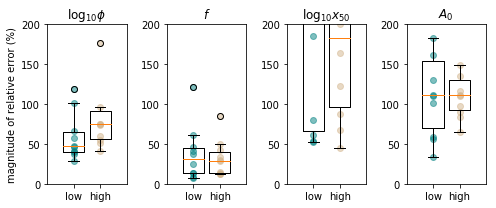

In [59]:
#plot percemt errors
plt.figure(figsize=(7,3))
for iid in range(len(D)):
    for v in range(len(short_varz_labels)):    
        plt.subplot(141+v)
        plt.scatter(np.ones(num_test)+iid/2,np.mean(rel_err_l,0)[iid,v,:],color=trialcolz[iid],alpha=0.5)
        plt.boxplot(np.mean(rel_err_l,0)[iid,v,:],positions=[1+iid/2],widths=0.4)    

        plt.title(short_varz_labels[v])
        if v==0:
            plt.ylabel('magnitude of relative error (%)')
        plt.xticks([1,1.5],['low','high'])
        
        plt.xlim([0.5,2])
        plt.ylim([0,200])
        #plt.xticks(range(len(short_varz_labels)),short_varz_labels)

plt.tight_layout()
plt.savefig('figures/gsense_pred3.pdf')


/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


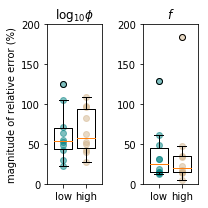

In [72]:
#plot percemt errors
#just top 2
plt.figure(figsize=(3,3))
for iid in range(len(D)):
    for v in range(2):    
        plt.subplot(121+v)
        plt.scatter(np.ones(num_test)+iid/2,np.mean(rel_err_l,0)[iid,v,:],color=trialcolz[iid],alpha=0.5)
        plt.boxplot(np.mean(rel_err_l,0)[iid,v,:],positions=[1+iid/2],widths=0.4)    

        plt.title(short_varz_labels[v])
        if v==0:
            plt.ylabel('magnitude of relative error (%)')
        plt.xticks([1,1.5],['low','high'])
        
        plt.xlim([0.65,1.85])
        plt.ylim([0,200])
        #plt.xticks(range(len(short_varz_labels)),short_varz_labels)

plt.tight_layout()
plt.savefig('figures/gsense_pred32.pdf')
